# Thesis Progress Summary: RDF Graph Embedding & Analysis

## Project Overview

- Goal: Explore semantic similarity between entities in RDF-based graph data (SickBins dataset).
- Approach: Convert RDF graph into node embeddings, visualize and quantify relationships, and analyze clusters.

---

## Steps Completed

### 1. Data Understanding & Preparation
- Explored RDF `.ttl` files: sample, taxonomy, and alignment.
- Identified data structure: semantic graph, sparse numeric fields.
- Merged taxonomy to enrich graph structure.

### 2. Embedding Creation
- Converted RDF data into NetworkX graph.
- Generated Node2Vec embeddings to capture semantic proximities.
- Successfully created vector representations for all nodes.

### 3. Visualization
- Visualized embeddings with t-SNE.
- Initial clusters visible, improved further after taxonomy enrichment.
- Created node similarity heatmap for top 30 nodes.

### 4. Node Type Inference
- Attempted neighbor-based inference for "Unknown" nodes.
- Limited improvement (6 additional nodes classified), documented.

### 5. Similarity Analysis
- Calculated cosine similarity matrix for node embeddings.
- Exported top similarities to CSV for reporting.
- Visualized similarity relationships through heatmap.

### 6. Clustering Analysis
- Performed K-Means clustering on embeddings.
- Visualized clusters on t-SNE plot.
- Analyzed dominant node types in each cluster:
  - Cluster 1: TargetObject focus
  - Cluster 3: Image nodes clustered
  - Other clusters showed taxonomy or unknown node groupings.
- Calculated Silhouette Score: 0.2683, indicating moderate cluster separation.

---

## Insights Collected

- Node embeddings successfully capture semantic relationships in the RDF graph.
- Taxonomy enrichment improved cluster visibility and semantic coherence.
- Clustering reveals logical groupings of data types, such as TargetObject and Image clusters.
- Quantitative metrics (similarity scores, silhouette score) support visual findings.

In [216]:
import numpy as np  
import pandas as pd
from rdflib import Graph, URIRef
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity




In [217]:

# Specify your TTL files
ttl_files = {
    "sample": "Master-EDA/sickbins-sample.ttl",  # Use this first for quick tests
    "full": "Master-EDA/sickbins.ttl",            # Main dataset
    "taxonomy": "Master-EDA/sickbins-taxonomy.ttl", # Taxonomy relationships
    "alignment": "Master-EDA/alignment.ttl"
}

# Function to load a TTL file
def load_graph(ttl_path):
    g = Graph()
    g.parse(ttl_path, format="turtle")
    print(f" Loaded {ttl_path}: {len(g)} triples found.")
    return g


In [218]:

# Load sample dataset first
graph_sample = load_graph(ttl_files["sample"])
# Load the taxonomy TTL file using your function
g_taxonomy = load_graph(ttl_files["taxonomy"])
# Load the alignment TTL file
g_alignment = load_graph(ttl_files["alignment"])



 Loaded Master-EDA/sickbins-sample.ttl: 440 triples found.
 Loaded Master-EDA/sickbins-taxonomy.ttl: 176 triples found.
 Loaded Master-EDA/alignment.ttl: 103 triples found.


In [219]:

# Merge taxonomy into sample graph
graph_sample += g_taxonomy

print(f"✅Merged graphs: Total triples now: {len(graph_sample)}")

# Convert RDF graph to NetworkX graph
nx_graph = nx.DiGraph()

for s, p, o in graph_sample:
    nx_graph.add_edge(str(s), str(o), label=str(p))

print(f" Converted RDF graph to NetworkX: {nx_graph.number_of_nodes()} nodes, {nx_graph.number_of_edges()} edges.")


✅Merged graphs: Total triples now: 616
 Converted RDF graph to NetworkX: 267 nodes, 571 edges.


In [220]:

# Step 1: Run node2vec on your NetworkX graph
node2vec = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

print("node2vec embedding completed.")


Computing transition probabilities:   0%|          | 0/267 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 3924.09it/s]


node2vec embedding completed.


In [221]:

# Step 2: Prepare embeddings for t-SNE
labels = model.wv.index_to_key
vectors = np.array([model.wv[node] for node in labels])  # ✅ Changed this



In [222]:

# Step 3: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000)
embeddings_2d = tsne.fit_transform(vectors)

print(" t-SNE dimensionality reduction completed.")


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


 t-SNE dimensionality reduction completed.


In [223]:
from rdflib.namespace import RDF

# Step: Build node type mapping from RDF graph
node_types = {}

for subj, pred, obj in graph_sample:
    if pred == RDF.type:
        node_types[str(subj)] = str(obj).split('/')[-1]  # Clean up to get class name

print(f" Extracted types for {len(node_types)} nodes.")

# Step: Prepare colors based on node types
color_map = {
    'TargetObject': 'red',
    'Observation': 'blue',
    'Reading': 'green',
    'Image': 'purple',
    'PointCloud': 'orange',
    'Conveyor': 'cyan',
    'owl#Ontology': 'black',
    'owl#NamedIndividual': 'brown',
}


colors = []
for label in labels:
    node_type = node_types.get(label, None)
    color = color_map.get(node_type, 'gray')  # Default to gray if type unknown
    colors.append(color)

print(f" Assigned colors based on RDF types.")
print(f"Node types extracted: {len(node_types)}")
print(f"Types found: {set(node_types.values())}")


 Extracted types for 106 nodes.
 Assigned colors based on RDF types.
Node types extracted: 106
Types found: {'owl#Ontology', 'core#Concept', 'PointCloud', 'Metadata', 'MeasurementSample', 'Reading', 'TargetObject', 'owl#NamedIndividual', 'Observation', 'Taxonomy', 'Image', 'core#ConceptScheme', 'Bin', 'Conveyor'}


 Plot saved as 'node2vec_tsne_visualization.png'.


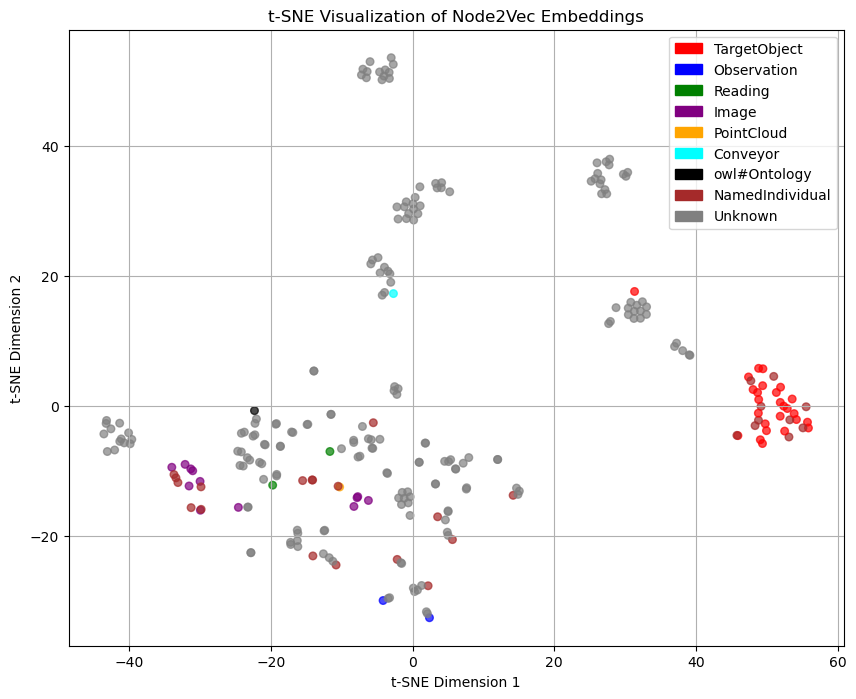

In [224]:
#scatter plot with assigned colors
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=30, alpha=0.7)

# Add legend manually
legend_elements = [
    mpatches.Patch(color='red', label='TargetObject'),
    mpatches.Patch(color='blue', label='Observation'),
    mpatches.Patch(color='green', label='Reading'),
    mpatches.Patch(color='purple', label='Image'),
    mpatches.Patch(color='orange', label='PointCloud'),
    mpatches.Patch(color='cyan', label='Conveyor'),
    mpatches.Patch(color='black', label='owl#Ontology'),
    mpatches.Patch(color='brown', label='NamedIndividual'),
    mpatches.Patch(color='gray', label='Unknown'),
]

plt.legend(handles=legend_elements, loc='best')
plt.title("t-SNE Visualization of Node2Vec Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Save the plot before showing it
plt.savefig("node2vec_tsne_visualization.png", dpi=300)
print(" Plot saved as 'node2vec_tsne_visualization.png'.")

plt.show()


## Insights from Taxonomy-Enriched Graph

- Merging taxonomy.ttl improved semantic structure of the graph.
- Clusters became more distinct, especially the red 'TargetObject' group.
- Colored nodes reflect known RDF types, while gray nodes lack explicit typing.
- Taxonomy triples created new paths, helping node2vec capture deeper relationships.
- Overall, embeddings now better reflect hierarchy and semantic proximity.


In [225]:
print(f"Node types extracted: {len(node_types)}")
print(f"Types found: {set(node_types.values())}")


Node types extracted: 106
Types found: {'owl#Ontology', 'core#Concept', 'PointCloud', 'Metadata', 'MeasurementSample', 'Reading', 'TargetObject', 'owl#NamedIndividual', 'Observation', 'Taxonomy', 'Image', 'core#ConceptScheme', 'Bin', 'Conveyor'}


## Node Similarity Insights

- **TargetObject** node shows high similarity with concept identifiers and category codes, indicating good semantic clustering.
- **Image** node is closely related to sensor output files and image formats (e.g., .png), validating the embedding quality.
- **Unknown node** still exhibits meaningful similarity to identifiers and test codes, showing the embedding's robustness even for untyped nodes.


## Node Similarity Calculation


In [226]:

# Convert list of vectors to numpy array
vectors_array = np.array(vectors)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(vectors_array)

print(f" Computed cosine similarity matrix of shape {similarity_matrix.shape}.")


 Computed cosine similarity matrix of shape (267, 267).


In [227]:
# Function to print top similar nodes for a given node
def print_top_similar_nodes(node_index, top_n=5):
    node_label = labels[node_index]
    similarities = similarity_matrix[node_index]
    
    # Get top similar node indices (excluding itself)
    top_indices = similarities.argsort()[::-1][1:top_n+1]
    
    print(f"\nTop {top_n} nodes similar to '{node_label}':")
    for idx in top_indices:
        print(f"{labels[idx]} - Similarity: {similarities[idx]:.4f}")

# Example: check for the first node
print_top_similar_nodes(0, top_n=5)



Top 5 nodes similar to 'http://www.w3.org/2002/07/owl#NamedIndividual':
https://data.sick.com/voc/trackandtrace/TargetObject - Similarity: 0.8652
Refactoring to a class recommended. - Similarity: 0.6981
CCM - Similarity: 0.6971
https://data.sick.com/res/sickbins/97a1553d-3ac4-46c0-94ae-d3cfc248504a - Similarity: 0.6831
CM - Similarity: 0.6808


In [228]:
# Helper to print similarities for any node label
def print_similarities_for_label(label_query, top_n=5):
    if label_query not in labels:
        print(f"Node '{label_query}' not found.")
        return
    index = labels.index(label_query)
    print_top_similar_nodes(index, top_n)

# Example usage:
print_similarities_for_label('https://data.sick.com/voc/trackandtrace/TargetObject')
print_similarities_for_label('https://data.sick.com/voc/sickbins/Image')
print_similarities_for_label('https://data.sick.com/res/sickbins/97a1553d-3ac4-46c0-94ae-d3cfc248504a')



Top 5 nodes similar to 'https://data.sick.com/voc/trackandtrace/TargetObject':
Refactoring to a class recommended. - Similarity: 0.9126
CCM - Similarity: 0.9125
G - Similarity: 0.9039
CM - Similarity: 0.9027
18.0 - Similarity: 0.9021

Top 5 nodes similar to 'https://data.sick.com/voc/sickbins/Image':
png - Similarity: 0.9966
Sensor5 intensity left - Similarity: 0.9128
https://data.sick.com/res/sickbins/d413b53a-e43a-49c2-9d11-4bbb5454af11.Sensor3.dat.zip__Intensity.png - Similarity: 0.9123
Sensor5 intensity right - Similarity: 0.9100
Sensor5 Depth - Similarity: 0.9092

Top 5 nodes similar to 'https://data.sick.com/res/sickbins/97a1553d-3ac4-46c0-94ae-d3cfc248504a':
CCM - Similarity: 0.9012
1234567 - Similarity: 0.8981
18.0 - Similarity: 0.8981
Refactoring to a class recommended. - Similarity: 0.8940
3.0 - Similarity: 0.8932


In [229]:

# Create DataFrame for easy inspection
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

# Display top entries
similarity_df.head()


,http://www.w3.org/2002/07/owl#NamedIndividual,https://data.sick.com/voc/sickbins-taxonomy/1234567,https://data.sick.com/voc/trackandtrace/TargetObject,http://www.w3.org/2004/02/skos/core#Concept,https://data.sick.com/voc/sickbins-taxonomy/SignalTypes,https://data.sick.com/voc/sickbins-taxonomy/MaterialTypes,https://data.sick.com/voc/sickbins/Image,png,https://data.sick.com/voc/sickbins-taxonomy/ObjectTypes,https://data.sick.com/voc/sickbins-taxonomy/Intensity,...,https://data.sick.com/res/sickbins/a1efc252-9fea-4d59-b42b-eab08248e7a9,https://data.sick.com/res/sickbins/df721533-a106-4cc5-ba67-29d07fd9ef21,https://data.sick.com/res/sickbins/9abfdf55-e721-48a9-8b41-4c05c3c4ba59,https://data.sick.com/res/sickbins/54a0e257-d80c-4f1e-bb03-91716349734c,https://data.sick.com/res/sickbins/,https://data.sick.com/res/sickbins/Sensor2,https://data.sick.com/res/sickbins/Sensor3,https://data.sick.com/res/sickbins/Sensor4,https://data.sick.com/res/sickbins/Sensor5,https://data.sick.com/res/sickbins/Sensor1
http://www.w3.org/2002/07/owl#NamedIndividual,1.000000,0.560006,0.865238,0.205985,0.141493,0.300998,0.483511,0.490607,0.198171,0.217853,...,0.151527,0.262036,0.244002,0.273838,0.207175,0.474325,0.491086,0.379458,0.447924,0.454476
https://data.sick.com/voc/sickbins-taxonomy/1234567,0.560006,1.000000,0.852331,0.399666,0.197281,0.615789,0.066076,0.077260,0.504014,0.129843,...,0.672260,0.731276,0.720841,0.727057,0.313598,0.317032,0.412618,0.314313,0.306620,0.362101
https://data.sick.com/voc/trackandtrace/TargetObject,0.865238,0.852331,1.000000,0.349973,0.163745,0.540784,0.230541,0.244487,0.403655,0.115699,...,0.469675,0.564577,0.548473,0.571391,0.285916,0.496398,0.554219,0.415318,0.412823,0.505834
http://www.w3.org/2004/02/skos/core#Concept,0.205985,0.399666,0.349973,1.000000,0.604545,0.628963,0.305779,0.308939,0.604377,0.362636,...,0.458764,0.438446,0.457349,0.421282,0.232305,0.141505,0.163730,0.127814,0.097506,0.133341
https://data.sick.com/voc/sickbins-taxonomy/SignalTypes,0.141493,0.197281,0.163745,0.604545,1.000000,0.556609,0.635783,0.641287,0.593919,0.838720,...,0.326076,0.302902,0.306755,0.295817,0.394313,0.250133,0.077567,0.112814,0.219628,0.167400


In [230]:
from sklearn.cluster import KMeans

# Set number of clusters
num_clusters = 5  

# Fit KMeans on your node embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_array)

print(f" K-Means clustering completed. Found {num_clusters} clusters.")


 K-Means clustering completed. Found 5 clusters.


In [231]:
# Create DataFrame for cluster assignments
cluster_df = pd.DataFrame({
    'Node': labels,
    'Cluster': cluster_labels
})

print(cluster_df.head())


                                                Node  Cluster
0      http://www.w3.org/2002/07/owl#NamedIndividual        4
1  https://data.sick.com/voc/sickbins-taxonomy/12...        1
2  https://data.sick.com/voc/trackandtrace/Target...        1
3        http://www.w3.org/2004/02/skos/core#Concept        1
4  https://data.sick.com/voc/sickbins-taxonomy/Si...        2


/var/folders/9k/b4dr3gsj445chyd11dk1fbr00000gn/T/ipykernel_86769/3316845563.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', num_clusters)


 Clustered t-SNE plot saved as 'node2vec_tsne_clusters.png'.


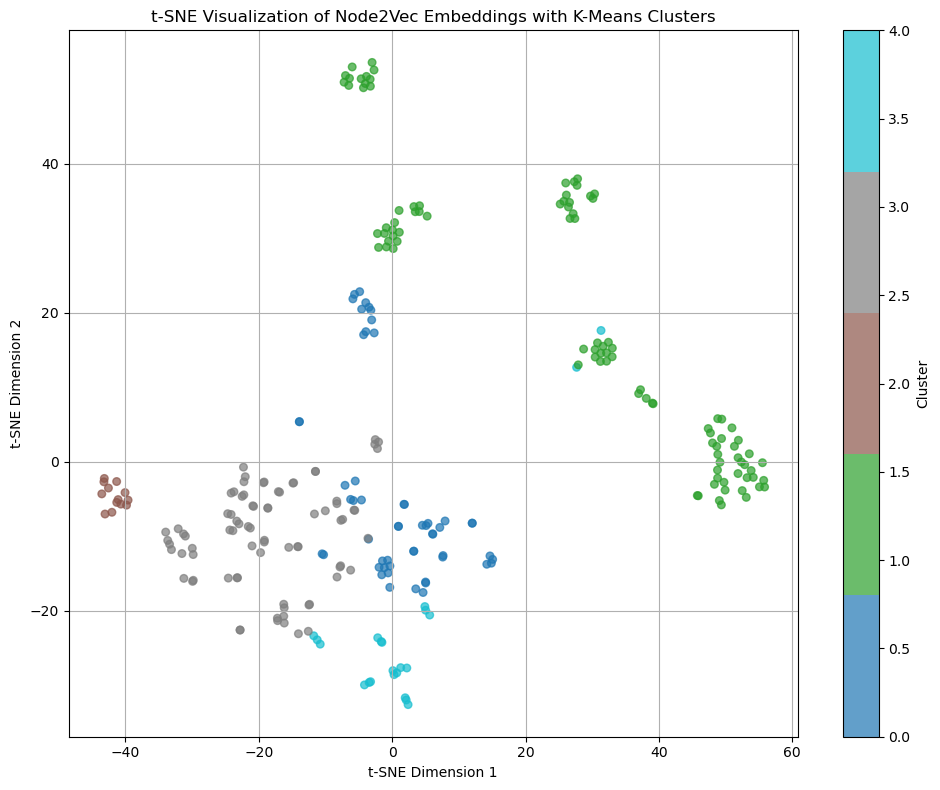

In [232]:

# Define color map for clusters
cluster_colors = plt.cm.get_cmap('tab10', num_clusters)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cluster_colors, s=30, alpha=0.7)

plt.title("t-SNE Visualization of Node2Vec Embeddings with K-Means Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label='Cluster')
plt.grid(True)

plt.tight_layout()
plt.savefig("node2vec_tsne_clusters.png", dpi=300)
print(" Clustered t-SNE plot saved as 'node2vec_tsne_clusters.png'.")

plt.show()


In [233]:
cluster_counts = cluster_df['Cluster'].value_counts()
print(" Cluster counts:\n", cluster_counts)


 Cluster counts:
 Cluster
1    99
3    79
0    54
4    22
2    13
Name: count, dtype: int64


In [234]:
from collections import Counter

# Prepare mapping node -> type
node_to_type = {}
for node_label in labels:
    node_type = node_types.get(node_label, 'Unknown')
    node_to_type[node_label] = node_type

# Analyze top node types per cluster
print("\n Top node types per cluster:")
for cluster_num in range(num_clusters):
    cluster_nodes = cluster_df[cluster_df['Cluster'] == cluster_num]['Node']
    types_in_cluster = [node_to_type.get(node, 'Unknown') for node in cluster_nodes]
    type_counts = Counter(types_in_cluster)
    print(f"\nCluster {cluster_num} ({len(cluster_nodes)} nodes):")
    for node_type, count in type_counts.most_common(3):
        print(f"  {node_type}: {count} nodes")



 Top node types per cluster:

Cluster 0 (54 nodes):
  Unknown: 38 nodes
  Metadata: 5 nodes
  owl#NamedIndividual: 4 nodes

Cluster 1 (99 nodes):
  Unknown: 47 nodes
  TargetObject: 25 nodes
  core#Concept: 13 nodes

Cluster 2 (13 nodes):
  Unknown: 7 nodes
  core#Concept: 5 nodes
  core#ConceptScheme: 1 nodes

Cluster 3 (79 nodes):
  Unknown: 54 nodes
  Image: 12 nodes
  owl#NamedIndividual: 10 nodes

Cluster 4 (22 nodes):
  Unknown: 15 nodes
  owl#NamedIndividual: 4 nodes
  Observation: 2 nodes


In [235]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score based on your embeddings and cluster labels
score = silhouette_score(vectors_array, cluster_labels)

print(f" Silhouette Score for K-Means clustering: {score:.4f}")


 Silhouette Score for K-Means clustering: 0.1894


In [236]:
'''# Get list of nodes labeled as "Unknown" (gray color)
gray_nodes = [label for label, color in zip(labels, colors) if color == 'gray']
print(f" Found {len(gray_nodes)} gray (unknown type) nodes.")
'''

'# Get list of nodes labeled as "Unknown" (gray color)\ngray_nodes = [label for label, color in zip(labels, colors) if color == \'gray\']\nprint(f" Found {len(gray_nodes)} gray (unknown type) nodes.")\n'

In [237]:
'''from collections import Counter

# Prepare mapping from label to node type (for faster lookup)
label_to_type = {}
for node_label in labels:
    node_type = node_types.get(node_label, 'Unknown')
    label_to_type[node_label] = node_type

# Analyze neighbors
gray_node_suggestions = {}

for gray_node in gray_nodes:
    neighbors = list(nx_graph.neighbors(gray_node))
    neighbor_types = [label_to_type.get(neighbor, 'Unknown') for neighbor in neighbors if neighbor in label_to_type]
    
    if neighbor_types:
        # Count neighbor types
        type_counts = Counter(neighbor_types)
        # Get the most common type (excluding 'Unknown')
        most_common_type = type_counts.most_common(1)[0][0]
        if most_common_type != 'Unknown':
            gray_node_suggestions[gray_node] = most_common_type

print(f" Suggested types for {len(gray_node_suggestions)} gray nodes based on neighbors.")
'''

'from collections import Counter\n\n# Prepare mapping from label to node type (for faster lookup)\nlabel_to_type = {}\nfor node_label in labels:\n    node_type = node_types.get(node_label, \'Unknown\')\n    label_to_type[node_label] = node_type\n\n# Analyze neighbors\ngray_node_suggestions = {}\n\nfor gray_node in gray_nodes:\n    neighbors = list(nx_graph.neighbors(gray_node))\n    neighbor_types = [label_to_type.get(neighbor, \'Unknown\') for neighbor in neighbors if neighbor in label_to_type]\n    \n    if neighbor_types:\n        # Count neighbor types\n        type_counts = Counter(neighbor_types)\n        # Get the most common type (excluding \'Unknown\')\n        most_common_type = type_counts.most_common(1)[0][0]\n        if most_common_type != \'Unknown\':\n            gray_node_suggestions[gray_node] = most_common_type\n\nprint(f" Suggested types for {len(gray_node_suggestions)} gray nodes based on neighbors.")\n'

In [238]:
'''print(f" Suggested types:  {gray_node_suggestions}.")
'''

'print(f" Suggested types:  {gray_node_suggestions}.")\n'

In [239]:
'''# Update colors list
new_colors = []

for label in labels:
    if label in gray_node_suggestions:
        suggested_type = gray_node_suggestions[label]
        color = color_map.get(suggested_type, 'gray')  # Fallback to gray
        new_colors.append(color)
    else:
        # Keep original color
        index = labels.index(label)
        new_colors.append(colors[index])

print(" Updated colors with neighbor-based suggestions.")
'''

'# Update colors list\nnew_colors = []\n\nfor label in labels:\n    if label in gray_node_suggestions:\n        suggested_type = gray_node_suggestions[label]\n        color = color_map.get(suggested_type, \'gray\')  # Fallback to gray\n        new_colors.append(color)\n    else:\n        # Keep original color\n        index = labels.index(label)\n        new_colors.append(colors[index])\n\nprint(" Updated colors with neighbor-based suggestions.")\n'

In [240]:
'''plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=new_colors, s=30, alpha=0.7)

# Keep the same legend
plt.legend(handles=legend_elements, loc='best')
plt.title("t-SNE Visualization with Inferred Node Types")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

plt.savefig("node2vec_tsne_inferred.png", dpi=300)
print(" Plot saved as 'node2vec_tsne_inferred.png'.")

plt.show()
'''

'plt.figure(figsize=(10, 8))\nplt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=new_colors, s=30, alpha=0.7)\n\n# Keep the same legend\nplt.legend(handles=legend_elements, loc=\'best\')\nplt.title("t-SNE Visualization with Inferred Node Types")\nplt.xlabel("t-SNE Dimension 1")\nplt.ylabel("t-SNE Dimension 2")\nplt.grid(True)\n\nplt.savefig("node2vec_tsne_inferred.png", dpi=300)\nprint(" Plot saved as \'node2vec_tsne_inferred.png\'.")\n\nplt.show()\n'

In [241]:
top_n = 5  # Change this if you want more or fewer results
similarities_list = []

for idx, node_label in enumerate(labels):
    similarities = similarity_matrix[idx]
    # Get top similar node indices (excluding itself)
    top_indices = similarities.argsort()[::-1][1:top_n+1]
    
    for similar_idx in top_indices:
        similar_node_label = labels[similar_idx]
        similarity_score = similarities[similar_idx]
        similarities_list.append({
            'Node': node_label,
            'Similar Node': similar_node_label,
            'Similarity Score': round(similarity_score, 4)
        })

import pandas as pd

# Create DataFrame
similarities_df = pd.DataFrame(similarities_list)

# Show top of DataFrame
print(similarities_df.head())


                                            Node  \
0  http://www.w3.org/2002/07/owl#NamedIndividual   
1  http://www.w3.org/2002/07/owl#NamedIndividual   
2  http://www.w3.org/2002/07/owl#NamedIndividual   
3  http://www.w3.org/2002/07/owl#NamedIndividual   
4  http://www.w3.org/2002/07/owl#NamedIndividual   

                                        Similar Node  Similarity Score  
0  https://data.sick.com/voc/trackandtrace/Target...            0.8652  
1                Refactoring to a class recommended.            0.6981  
2                                                CCM            0.6971  
3  https://data.sick.com/res/sickbins/97a1553d-3a...            0.6831  
4                                                 CM            0.6808  


In [242]:
# Export to CSV
similarities_df.to_csv('node_similarities.csv', index=False)
print("✅ Similarities exported to 'node_similarities.csv'.")


✅ Similarities exported to 'node_similarities.csv'.


In [243]:
# Shorten labels for readability
def shorten_label(label):
    if "#" in label:
        return label.split("#")[-1]
    elif "/" in label:
        return label.split("/")[-1]
    else:
        return label

short_labels = [shorten_label(label) for label in subset_labels]


✅ Heatmap saved as 'node_similarity_heatmap.png'.


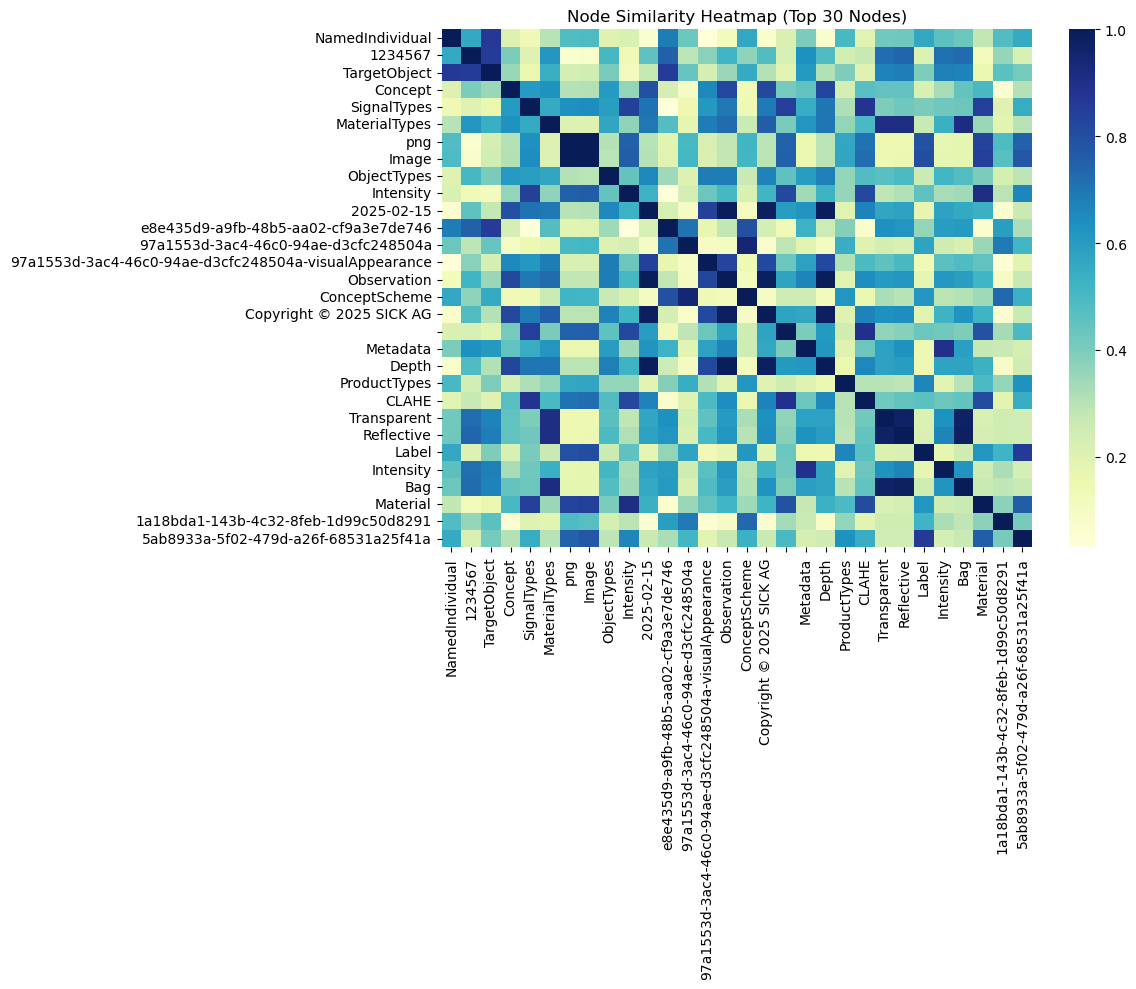

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

# For readability, limit to top N nodes (optional)
top_n_nodes = 30  # You can adjust this number
subset_labels = labels[:top_n_nodes]
subset_sim_matrix = similarity_df.loc[subset_labels, subset_labels]

plt.figure(figsize=(12, 10))
sns.heatmap(subset_sim_matrix, xticklabels=short_labels, yticklabels=short_labels, cmap="YlGnBu", annot=False)

plt.title("Node Similarity Heatmap (Top 30 Nodes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("node_similarity_heatmap.png", dpi=300)
print("✅ Heatmap saved as 'node_similarity_heatmap.png'.")

plt.show()


## Insights from Node Similarity Heatmap

- Clear clusters formed among semantic groups (e.g., TargetObject, NamedIndividual).
- Image-related nodes cluster tightly, indicating well-captured modality relationships.
- Taxonomy categories (ObjectTypes, SignalTypes) show moderate similarity, confirming distinct but related roles.
- Metadata and product-related nodes display meaningful cross-connections.
- Literal or isolated nodes appear as expected with lower similarity.
- Overall, the heatmap validates that node embeddings reflect underlying semantic structures in the RDF graph.
